## Preprocessing

TL;DR:
- Handles outliers and negative values in features like `SquareFootageHouse`, `Age`, and `HeatingCosts`.
- Visualizes data with boxplots before and after outlier correction.
- Removes rows with all NaN values
- Merges labels: `HeatingType` and `Location`
- Interpolates missing values in `HeatingCosts` using linear regression.
- Creates a new feature `WindowMaterial` based on `WindowModelNames`.
- Addresses remaining missing values and outlines further tasks like dealing with missing values and analyzing `SquareFootageGarden` clusters.

### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression

### Load dataset

In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# 
df = pd.read_csv('../files/data_6.csv', keep_default_na=False, na_values=[""])


df.head()


df['PoolQuality'].unique()

array(['Good', nan, 'Excellent', 'None', 'Poor'], dtype=object)

In [3]:
print(df.shape)

(1000, 23)


# Outliers - Numerical Features

TL;DR

Removed **54 Outliers**:
1. **After Removing Outliers and Fixing Negative Values in `SquareFootageHouse`**:
   - Number of rows decreased by 17 outliers and 4 negative values were fixed.
2. **After Outlier Removal in `Price`**:
   - Number of rows decreased by 21 outliers.

3. **After Fixing Negative Values in `HeatingCosts` and Removing Outliers**:
   - Number of rows decreased by 16 outliers and 7 negative values were fixed.



In [4]:
def identify_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] < lower_bound) | (df[column] > upper_bound)]

def identify_not_outliers(df, column, include_nan=True):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[((df[column] >= lower_bound) & (df[column] <= upper_bound)) | (include_nan and df[column].isnull())]

## Boxplot

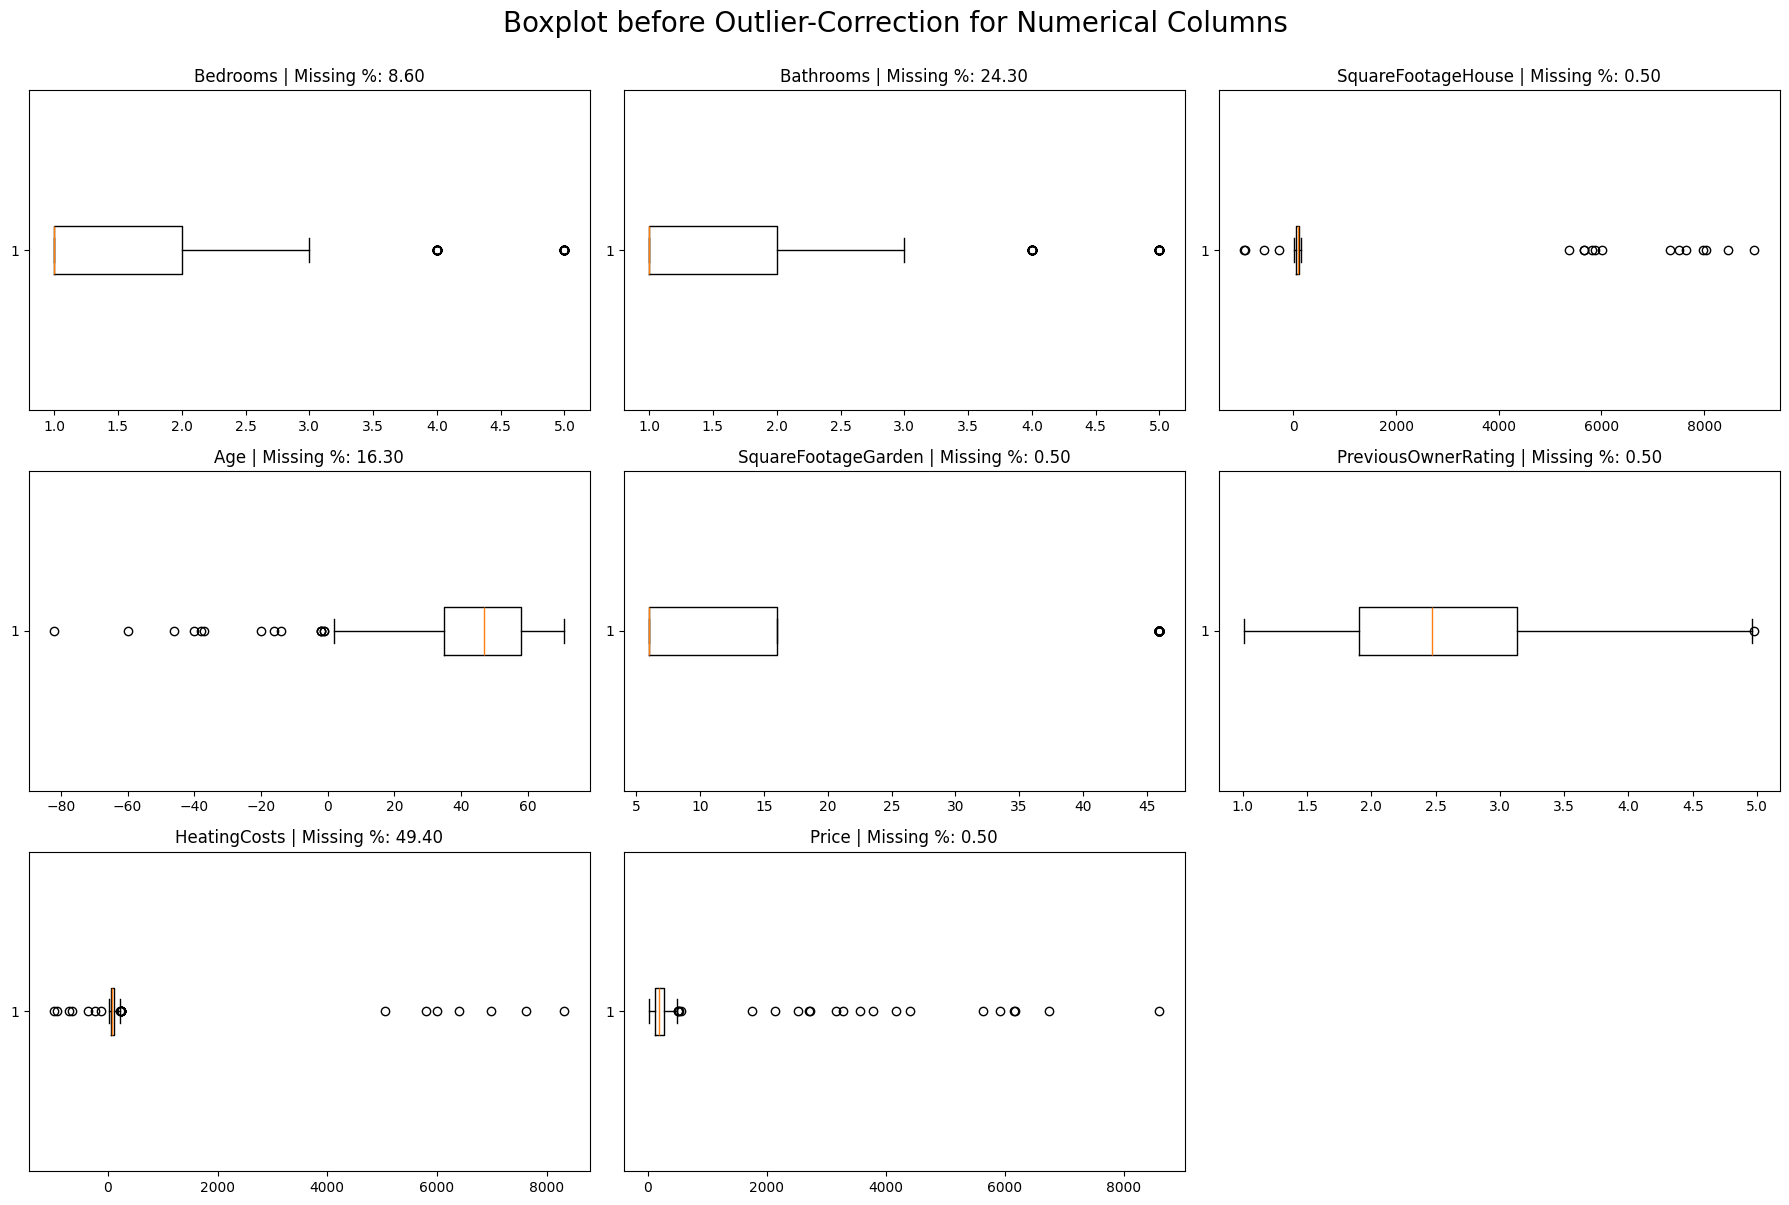

In [5]:
numerical_columns = df.select_dtypes(include=np.number).columns
numerical_missing_distribution = df[numerical_columns].isnull().mean() * 100

# Determine the number of rows and columns for subplots
num_features = len(numerical_columns)
num_cols = 3  # Number of columns for subplots
num_rows = (num_features - 1) // num_cols + 1  # Number of rows for subplots

# Set the figure size
plt.figure(figsize=(18, 4 * num_rows))
plt.suptitle("Boxplot before Outlier-Correction for Numerical Columns", fontsize=20, y=1)
# Plot histograms for each numerical feature
for i, column in enumerate(numerical_columns, 1):
    plt.subplot(num_rows, num_cols, i)
    plt.boxplot(df[column].dropna(), vert=False)
    plt.title(f'{column} | Missing %: {numerical_missing_distribution[column]:.2f}')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

## SquareFootageHouse ❌

1. 4 Negative Values fixed with absolute value
2. 17 Outliers with large values removed

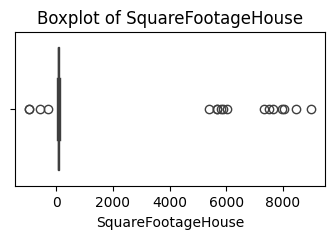

In [6]:
plt.figure(figsize=(4, 2))
sns.boxplot(x='SquareFootageHouse', data=df)
plt.title('Boxplot of SquareFootageHouse')
plt.xlabel('SquareFootageHouse')
plt.show()

In [7]:
df['SquareFootageHouse'].describe()

count     995.000000
mean      170.490452
std       794.871558
min      -957.000000
25%        52.000000
50%        84.000000
75%       117.000000
max      8979.000000
Name: SquareFootageHouse, dtype: float64

In [8]:
# 1. Use abs() for negative values
print("Negative SquareFootageHouse values: ", df[df['SquareFootageHouse'] < 0].shape[0])
df['SquareFootageHouse'] = df['SquareFootageHouse'].abs()
df['SquareFootageHouse'].describe().astype(int)

Negative SquareFootageHouse values:  4


count     995
mean      176
std       793
min        19
25%        52
50%        86
75%       118
max      8979
Name: SquareFootageHouse, dtype: int32

In [9]:
outliers_squarefootagehouse = identify_outliers(df, 'SquareFootageHouse')
outliers_squarefootagehouse['SquareFootageHouse'].describe().astype(int)

count      17
mean     5475
std      2947
min       270
25%      5374
50%      5869
75%      7644
max      8979
Name: SquareFootageHouse, dtype: int32

In [10]:
# 2. Remove Outliers
df = identify_not_outliers(df, 'SquareFootageHouse')
df['SquareFootageHouse'].describe().astype(int)

count    978
mean      83
std       37
min       19
25%       52
50%       83
75%      116
max      151
Name: SquareFootageHouse, dtype: int32

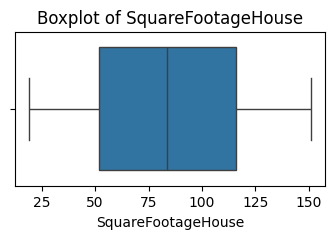

In [11]:
plt.figure(figsize=(4, 2))
sns.boxplot(x='SquareFootageHouse', data=df)
plt.title('Boxplot of SquareFootageHouse')
plt.xlabel('SquareFootageHouse')
plt.show()

## Age ❌
Contains negative values, so we will use the absolute value

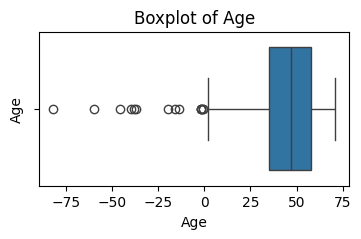

In [12]:
# Boxplot of Age
plt.figure(figsize=(4, 2))
sns.boxplot(x='Age', data=df)
plt.title('Boxplot of Age')
plt.ylabel('Age')
plt.show()

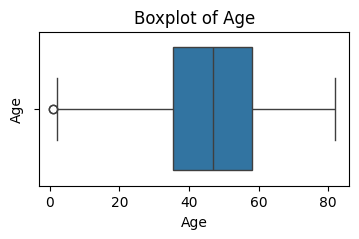

In [13]:
df['Age'] = df['Age'].abs()


# Boxplot of Age
plt.figure(figsize=(4, 2))
sns.boxplot(x='Age', data=df)
plt.title('Boxplot of Age')
plt.ylabel('Age')
plt.show()

## SquareFootageGarden (❓)

Small cluster exists with large garden across all house areas.
<a id='outlier_squarefootagegarden'></a>

In [14]:
df['SquareFootageGarden'].describe()

count    978.000000
mean      12.382413
std       11.102803
min        6.000000
25%        6.000000
50%        6.000000
75%       16.000000
max       46.000000
Name: SquareFootageGarden, dtype: float64

In [15]:
outliers_squarefootagegarden = identify_outliers(df, 'SquareFootageGarden')
print("Outliers in SquareFootageGarden: ", outliers_squarefootagegarden.shape)

Outliers in SquareFootageGarden:  (83, 23)


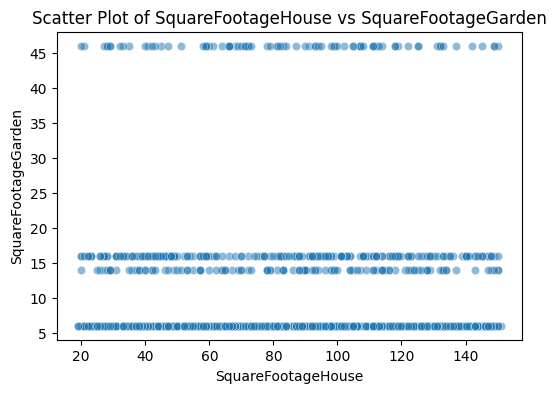

In [16]:
plt.figure(figsize=(6, 4))
sns.scatterplot(x='SquareFootageHouse', y='SquareFootageGarden', data=df, alpha=0.5)
plt.title('Scatter Plot of SquareFootageHouse vs SquareFootageGarden')
plt.xlabel('SquareFootageHouse')
plt.ylabel('SquareFootageGarden')
plt.show()

## Price ❌

21 Outliers with large prices. We will remove them.

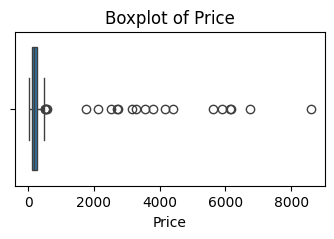

In [17]:
# boxplot for price
plt.figure(figsize=(4, 2))
sns.boxplot(x='Price', data=df)
plt.title('Boxplot of Price')
plt.xlabel('Price')
plt.show()

In [18]:
df['Price'].describe().round(0)

count     978.0
mean      274.0
std       600.0
min        24.0
25%       126.0
50%       183.0
75%       273.0
max      8598.0
Name: Price, dtype: float64

In [19]:
outliers_price = identify_outliers(df, 'Price')
print("Outliers w.r.t. Price:\n", outliers_price['Price'].describe().round(0))

Outliers w.r.t. Price:
 count      21.0
mean     3598.0
std      2290.0
min       511.0
25%      2138.0
50%      3282.0
75%      5636.0
max      8598.0
Name: Price, dtype: float64


In [20]:
df = identify_not_outliers(df, 'Price')

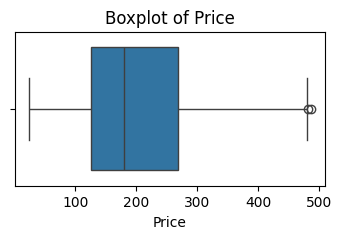

In [21]:
# boxplot for price
plt.figure(figsize=(4, 2))
sns.boxplot(x='Price', data=df)
plt.title('Boxplot of Price')
plt.xlabel('Price')
plt.show()

## HeatingCosts ❌

1. 7 Negatives fixed with absolute vale
2. 16 Outliers removed

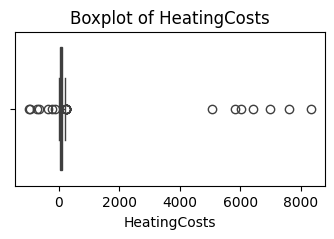

In [22]:
plt.figure(figsize=(4, 2))
sns.boxplot(x='HeatingCosts', data=df)
plt.title('Boxplot of HeatingCosts')
plt.xlabel('HeatingCosts')
plt.show()

In [23]:
print(df['HeatingCosts'].describe().round(0))

print("\n# NaN Values:", df['HeatingCosts'].isnull().sum())
print("# Negative Values:", df[df['HeatingCosts'] < 0].shape[0])
print("# Outliers:", identify_outliers(df, 'HeatingCosts').shape[0])

count     487.0
mean      173.0
std       794.0
min      -981.0
25%        48.0
50%        76.0
75%       120.0
max      8326.0
Name: HeatingCosts, dtype: float64

# NaN Values: 475
# Negative Values: 7
# Outliers: 24


In [24]:
# 1. Use abs() for negative values
df['HeatingCosts'] = df['HeatingCosts'].abs()
print(df['HeatingCosts'].describe().round(0))

print("\n# NaN Values:", df['HeatingCosts'].isnull().sum())
print("# Negative Values:", df[df['HeatingCosts'] < 0].shape[0])
print("# Outliers:", identify_outliers(df, 'HeatingCosts').shape[0])

count     487.0
mean      189.0
std       790.0
min        12.0
25%        50.0
50%        79.0
75%       123.0
max      8326.0
Name: HeatingCosts, dtype: float64

# NaN Values: 475
# Negative Values: 0
# Outliers: 16


In [25]:
# 2. Remove Outliers
df = identify_not_outliers(df, 'HeatingCosts', include_nan=True)
print(df['HeatingCosts'].describe().round(0))

print("\n# NaN Values:", df['HeatingCosts'].isnull().sum())
print("# Negative Values:", df[df['HeatingCosts'] < 0].shape[0])

count    471.0
mean      88.0
std       51.0
min       12.0
25%       49.0
50%       76.0
75%      118.0
max      232.0
Name: HeatingCosts, dtype: float64

# NaN Values: 475
# Negative Values: 0


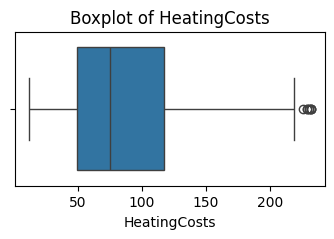

In [26]:
plt.figure(figsize=(4, 2))
sns.boxplot(x='HeatingCosts', data=df)
plt.title('Boxplot of HeatingCosts')
plt.xlabel('HeatingCosts')
plt.show()

## Boxplot Post-Preprocessing

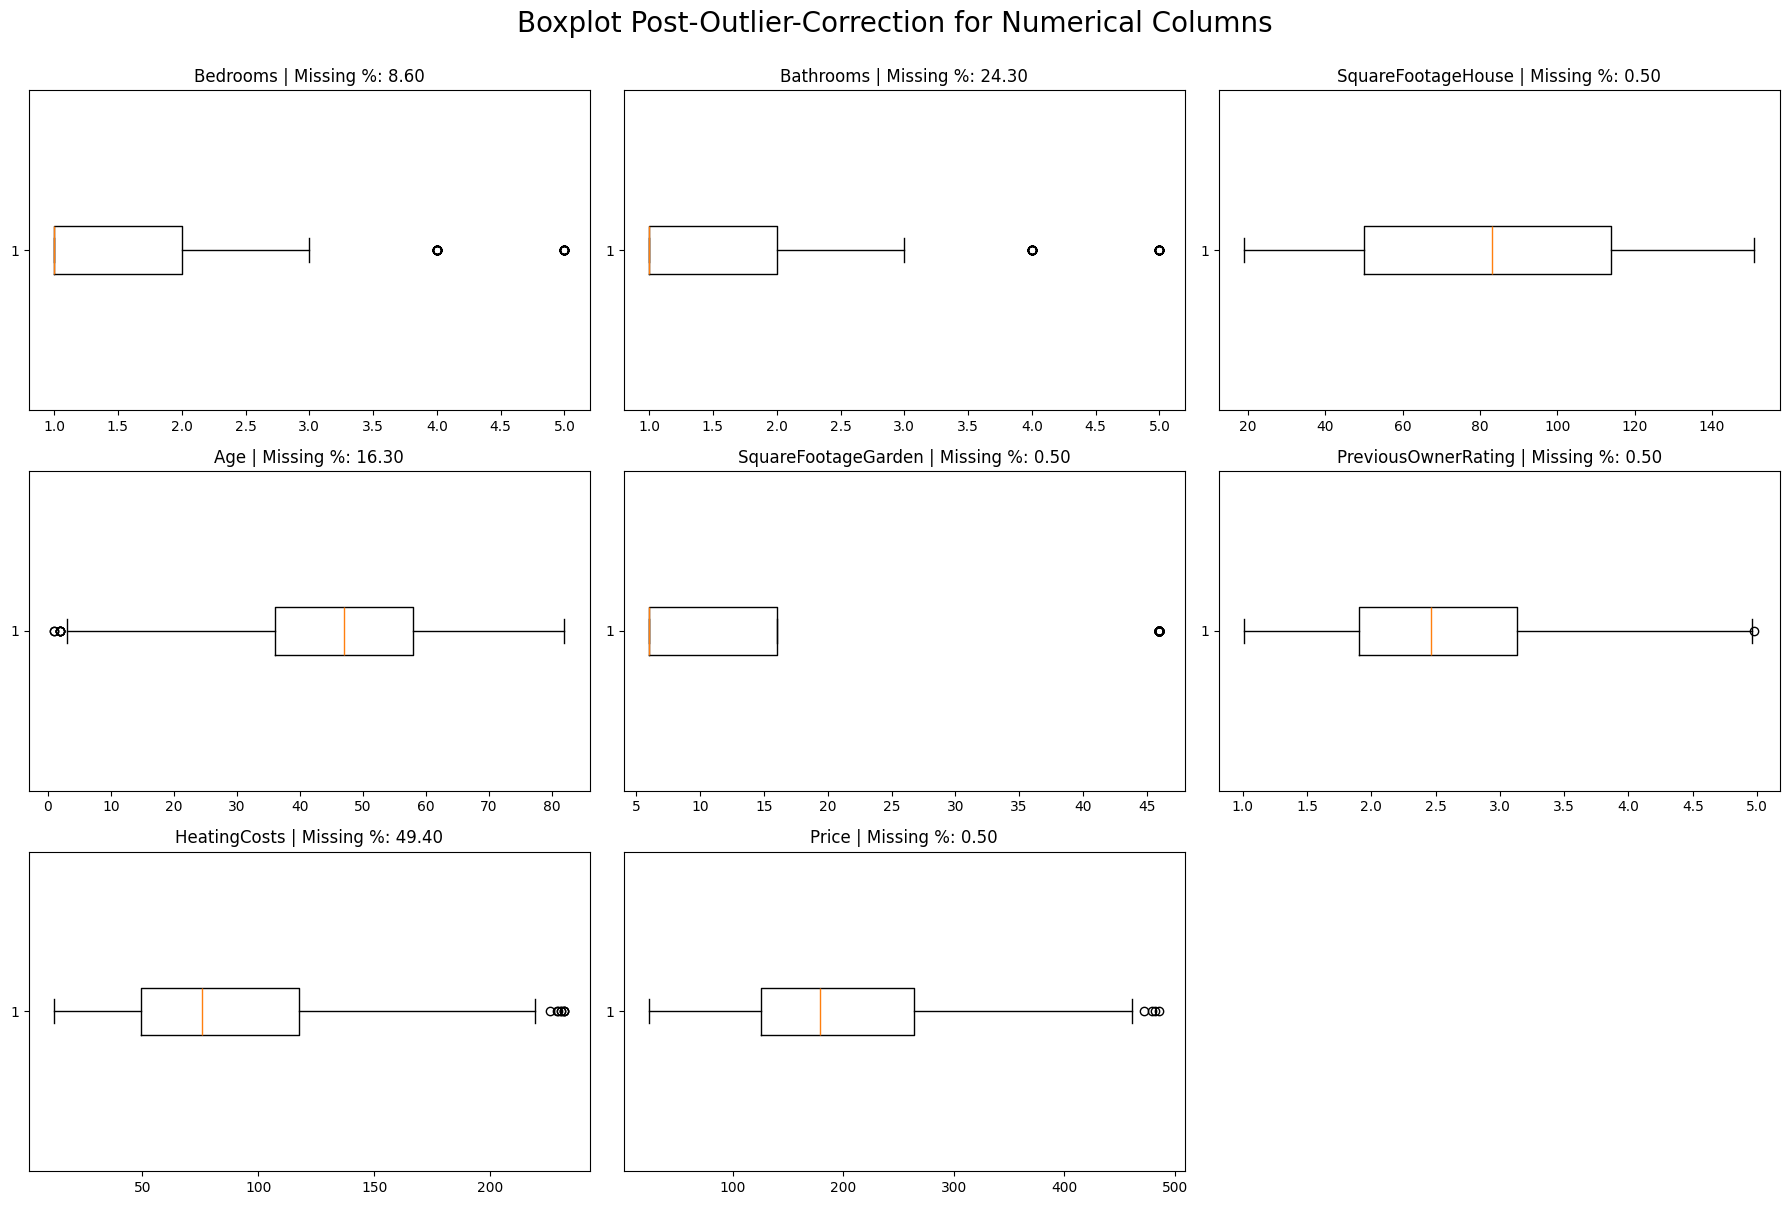

In [27]:
# Set the figure size
plt.figure(figsize=(18, 4 * num_rows))
plt.suptitle("Boxplot Post-Outlier-Correction for Numerical Columns", fontsize=20, y=1)
# Plot histograms for each numerical feature
for i, column in enumerate(numerical_columns, 1):
    plt.subplot(num_rows, num_cols, i)
    plt.boxplot(df[column].dropna(), vert=False)
    plt.title(f'{column} | Missing %: {numerical_missing_distribution[column]:.2f}')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

# Feature Engineering

## NaN Rows
5 NaN Rows removed

In [28]:
# Print number of entries
print("# Total after Outlier Removal: ", df.shape)

df = df.dropna(how='all')

print("# Entries after dropping rows with all NaN values: ", df.shape)

# Total after Outlier Removal:  (946, 23)
# Entries after dropping rows with all NaN values:  (941, 23)


## HeatingType
Merge heating types

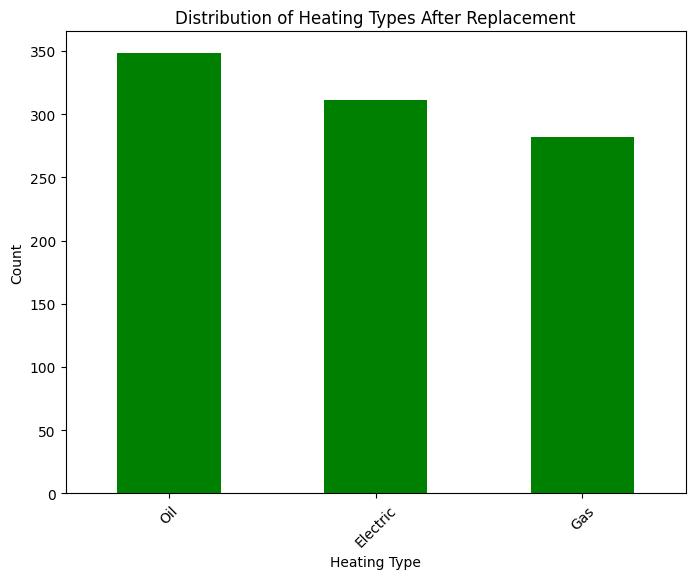

In [29]:
df['HeatingType'] = df['HeatingType'].replace({'Oil Heating': 'Oil', 'Electricity': 'Electric'})

plt.figure(figsize=(8, 6))
df['HeatingType'].value_counts().plot(kind='bar', color='green')
plt.title('Distribution of Heating Types After Replacement')
plt.xlabel('Heating Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

## HeatingType vs. HasPhotovoltaics

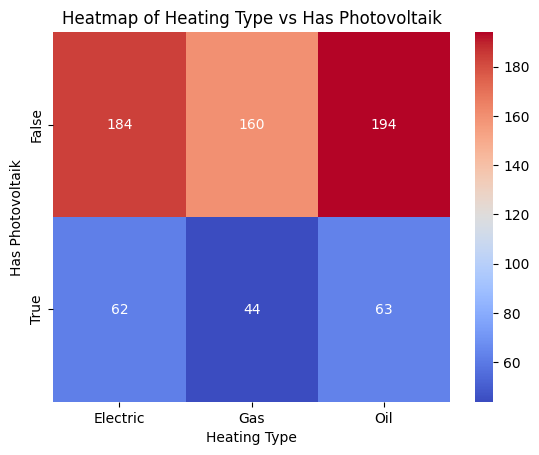

In [30]:
filtered_df = df[df['HeatingType'].isin(['Electric', 'Oil', 'Gas'])]

filtered_df = df.dropna(subset=['HasPhotovoltaics'])

filtered_df = filtered_df[filtered_df['HeatingType'].isin(['Electric', 'Oil', 'Gas'])]

pivot_table = filtered_df.pivot_table(columns='HeatingType', index='HasPhotovoltaics', aggfunc='size', fill_value=0)

sns.heatmap(pivot_table, annot=True, fmt='d', cmap='coolwarm')

plt.ylabel('Has Photovoltaik')
plt.xlabel('Heating Type')
plt.title('Heatmap of Heating Type vs Has Photovoltaik')
plt.show()

## HeatingCosts Interpolation

Interpolating missing values using linear regression model `x = SquareFootageHouse` and `y = HeatingCosts`

In [32]:
selected_heating_types = ['Oil', 'Electric', 'Gas']

filtered_df = df[df['SquareFootageHouse'] >= 0]
filtered_df = df[df['HeatingCosts'] >= 0]

filtered_df.describe()

,Bedrooms,Bathrooms,SquareFootageHouse,Age,SquareFootageGarden,PreviousOwnerRating,HeatingCosts,Price
count,435.000000,358.000000,471.000000,390.000000,471.000000,471.000000,471.000000,471.000000
mean,1.629885,1.701117,82.133758,44.938462,12.505308,2.588280,87.898089,199.240499
std,0.952091,1.008396,36.977008,15.477035,11.779873,0.865465,50.605151,99.913530
min,1.000000,1.000000,20.000000,1.000000,6.000000,1.010000,12.000000,24.146300
25%,1.000000,1.000000,48.000000,35.000000,6.000000,1.920000,49.300000,121.194000
50%,1.000000,1.000000,83.000000,46.000000,6.000000,2.490000,75.600000,181.560890
75%,2.000000,2.000000,113.000000,57.000000,16.000000,3.095000,117.500000,268.339535
max,5.000000,5.000000,151.000000,71.000000,46.000000,4.980000,232.000000,486.070420


# heating_type='Oil' (170, 23)
# heating_type='Electric' (148, 23)
# heating_type='Gas' (153, 23)
Remaining rows in the dataset:  (941, 23)


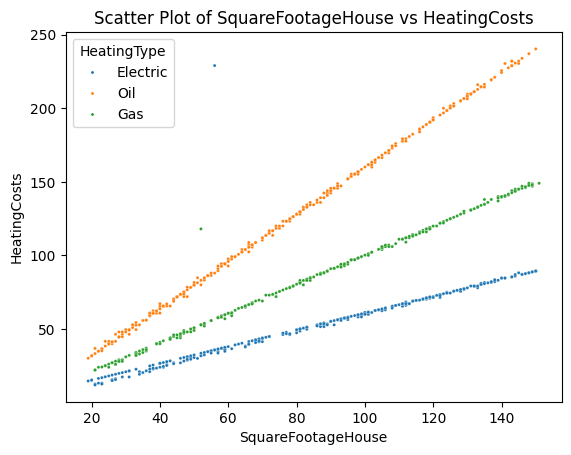

In [33]:
for heating_type in selected_heating_types:
    subset_df = filtered_df[filtered_df['HeatingType'] == heating_type]
    print(f"# {heating_type=} {subset_df.shape}")
    X = subset_df[['SquareFootageHouse']]
    y = subset_df['HeatingCosts']
    model = LinearRegression()
    model.fit(X, y)

    missing_values_df = df[(df['HeatingType'] == heating_type) & df['HeatingCosts'].isna()]
    if not missing_values_df.empty:
        X_missing = missing_values_df[['SquareFootageHouse']]
        y_pred = model.predict(X_missing)
        df.loc[missing_values_df.index, 'HeatingCosts'] = y_pred
    
print("Remaining rows in the dataset: ", df.shape)

sns.scatterplot(x=df['SquareFootageHouse'], y=df['HeatingCosts'], hue='HeatingType', data=df, alpha=1, s=5, color='Set1')
plt.xlabel('SquareFootageHouse')
plt.ylabel('HeatingCosts')
plt.title('Scatter Plot of SquareFootageHouse vs HeatingCosts')
plt.show()

In [34]:
df['HeatingCosts'].describe()
print("# NaN Values: ", df['HeatingCosts'].isnull().sum())

# NaN Values:  0


## PreviousOwnerName Removed

Remove Names of previous owners

In [37]:
df.drop(columns=['PreviousOwnerName'], inplace=True)

## Window Feature Created

In [38]:
framematerials = ["Wood", "Steel", "Aluminum"]

window_materials = []

for index, row in df.iterrows():
    window_model = row['WindowModelNames']
    for material in framematerials:
        if material in window_model:
            window_materials.append(material)
            break  
    else:
        window_materials.append("")  # Missing value if there is any

# Insert the new column at the end of the datafradme
df.insert(len(df.columns), 'WindowMaterial', window_materials)

missing_values_count = df['WindowMaterial'].isna().sum()
print("Missing values in 'WindowMaterial' column:", missing_values_count)

df.head()

Missing values in 'WindowMaterial' column: 0


,Bedrooms,Bathrooms,SquareFootageHouse,Location,Age,PoolQuality,HasPhotovoltaics,HeatingType,HasFiberglass,IsFurnished,DateSinceForSale,HouseColor,HasFireplace,KitchensQuality,BathroomsQuality,BedroomsQuality,LivingRoomsQuality,SquareFootageGarden,PreviousOwnerRating,HeatingCosts,WindowModelNames,Price,WindowMaterial
0,1.0,2.0,127.0,Rural,69.0,Good,False,Electric,True,True,2023-09-25,Yellow,False,Good,Good,Good,Good,16.0,1.33,76.243384,M3VPE Wood LQRCLH,346.57594,Wood
1,3.0,3.0,129.0,Rural,65.0,NaN,True,Oil,False,False,2022-09-22,Gray,False,Poor,Good,Excellent,Poor,16.0,1.52,206.609811,E5BJG Steel BVYWGBZ Window,429.91007,Steel
2,1.0,2.0,99.0,Urban,43.0,Excellent,False,Electric,True,True,2022-05-01,White,False,Good,Good,Excellent,Poor,46.0,2.49,59.400000,Aluminum 263R,243.80271,Aluminum
3,2.0,NaN,126.0,Rural,35.0,NaN,False,Oil,False,False,2020-12-10,White,False,Good,Good,Good,Good,6.0,1.44,201.600000,Steel 3K90,378.22772,Steel
4,1.0,3.0,101.0,Rural,54.0,NaN,NaN,Electric,False,True,2022-09-24,Gray,False,Excellent,Poor,Poor,Good,6.0,1.88,60.000000,U6Y6P Wood BJ7 Window,249.67852,Wood


In [39]:
df.drop(columns=['WindowModelNames'], inplace=True)

df['WindowMaterial'].unique()

array(['Wood', 'Steel', 'Aluminum'], dtype=object)

## Location

In [40]:
df['Location'] = df['Location'].replace('Suburbann', 'Suburban')
distinct_locations = df['Location'].unique()
print(distinct_locations)

['Rural' 'Urban' 'Suburban' nan]


## DateSinceForSale

In [41]:
df['DateSinceForSale'].unique()

# Convert to datetime
df['DateSinceForSale'] = pd.to_datetime(df['DateSinceForSale'], format='%Y-%m-%d')

## Ranks for "Quality" Features

In [39]:
quality_columns = ['PoolQuality', 'KitchensQuality', 'BathroomsQuality', 'BedroomsQuality', 'LivingRoomsQuality']

quality_rank_mapping = {'None': -1, 'Poor': 0, 'Good': 1, 'Excellent': 2}

df[quality_columns].head()

,PoolQuality,KitchensQuality,BathroomsQuality,BedroomsQuality,LivingRoomsQuality
0,Good,Good,Good,Good,Good
1,NaN,Poor,Good,Excellent,Poor
2,Excellent,Good,Good,Excellent,Poor
3,NaN,Good,Good,Good,Good
4,NaN,Excellent,Poor,Poor,Good


In [40]:
for column in quality_columns:
    df[column] = df[column].replace(quality_rank_mapping)

C:\Users\alexb\AppData\Local\Temp\ipykernel_15248\428641738.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[column] = df[column].replace(quality_rank_mapping)


## Rank for WindowMaterial

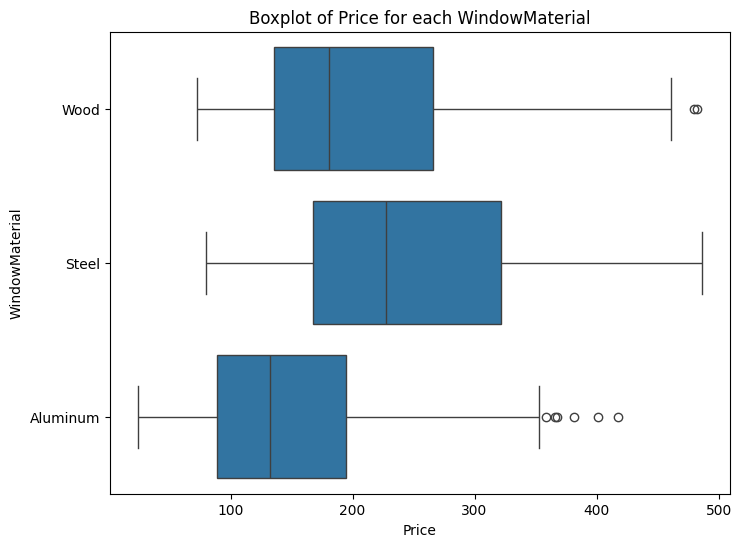

In [42]:
# Plot boxplot of price for each WindowMaterial
plt.figure(figsize=(8, 6))
sns.boxplot(x='Price', y='WindowMaterial', data=df)
plt.title('Boxplot of Price for each WindowMaterial')
plt.xlabel('Price')
plt.ylabel('WindowMaterial')
plt.show()


In [42]:
df['WindowMaterial'] = df['WindowMaterial'].replace({'Wood': 1, 'Steel': 2, 'Aluminum': 0})

C:\Users\alexb\AppData\Local\Temp\ipykernel_15248\291511092.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['WindowMaterial'] = df['WindowMaterial'].replace({'Wood': 1, 'Steel': 2, 'Aluminum': 0})


In [43]:
# Correlation matrix
df['WindowMaterial'].corr(df['Price'])

0.40121330584436404

## Rank for Location


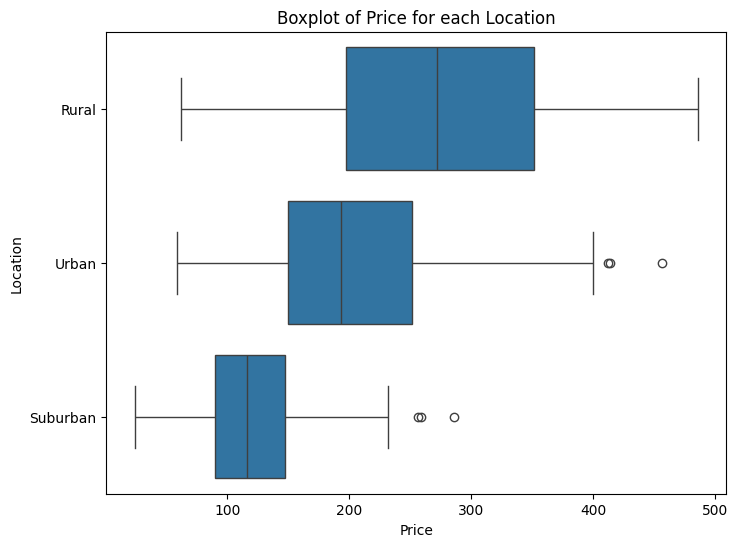

In [44]:
# Plot boxplot of price for each WindowMaterial
plt.figure(figsize=(8, 6))
sns.boxplot(x='Price', y='Location', data=df)
plt.title('Boxplot of Price for each Location')
plt.xlabel('Price')
plt.ylabel('Location')
plt.show()

In [45]:
df['Location'] = df['Location'].replace({'Suburban': 0, 'Urban': 1, 'Rural': 2})

C:\Users\alexb\AppData\Local\Temp\ipykernel_15248\3811329787.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Location'] = df['Location'].replace({'Suburban': 0, 'Urban': 1, 'Rural': 2})


In [46]:
df['Location'].corr(df['Price'])

0.6438131630527729

## Rank for HasFiberglass

In [47]:
df['HasFiberglass'].unique()

array([True, False], dtype=object)

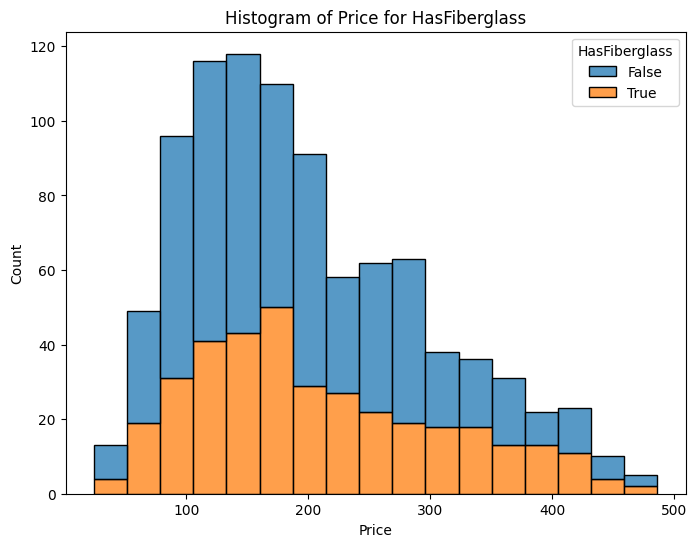

In [48]:
# Plot Histogram of HasFiberglass Price
plt.figure(figsize=(8, 6))
sns.histplot(x='Price', hue='HasFiberglass', data=df,  multiple='stack')
plt.title('Histogram of Price for HasFiberglass')
plt.xlabel('Price')
plt.show()


In [49]:
df['HasFiberglass'] = df['HasFiberglass'].replace({True: 1, False: 0})

C:\Users\alexb\AppData\Local\Temp\ipykernel_15248\1609535639.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['HasFiberglass'] = df['HasFiberglass'].replace({True: 1, False: 0})


In [50]:
df['HasFiberglass'].corr(df['Price'], method='pearson')

0.07163536789109641

## Rank for HeatingType

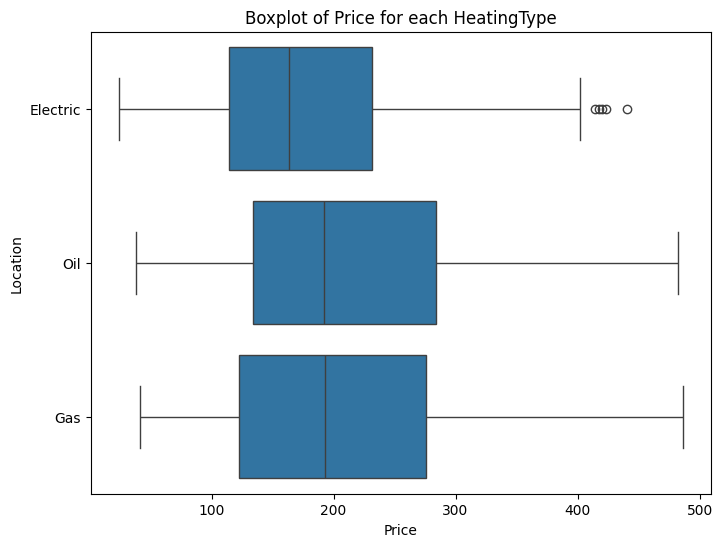

In [51]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='Price', y='HeatingType', data=df)
plt.title('Boxplot of Price for each HeatingType')
plt.xlabel('Price')
plt.ylabel('Location')
plt.show()

In [52]:
df['HeatingType'] = df['HeatingType'].replace({'Electric': 0, 'Oil': 2, 'Gas': 1})

df['HeatingType'].corr(df['Price'])

C:\Users\alexb\AppData\Local\Temp\ipykernel_15248\2851438432.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['HeatingType'] = df['HeatingType'].replace({'Electric': 0, 'Oil': 2, 'Gas': 1})


0.1521210417256221

## Rank for IsFurnished

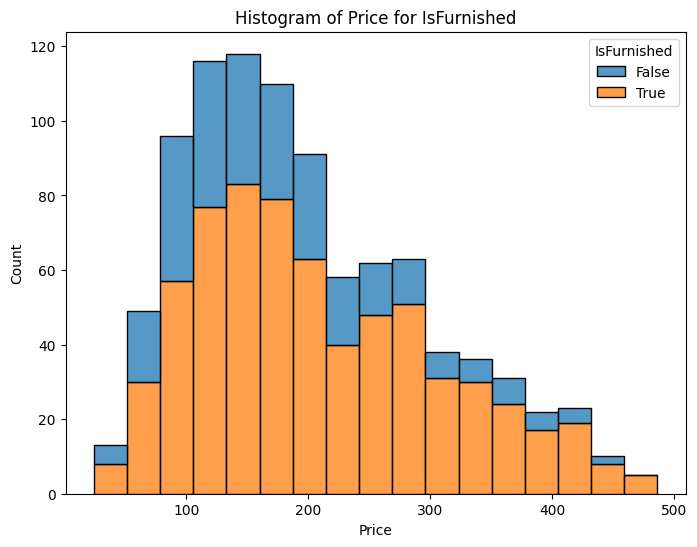

In [53]:
plt.figure(figsize=(8, 6))
sns.histplot(x='Price', hue='IsFurnished', data=df, multiple='stack')
plt.title('Histogram of Price for IsFurnished')
plt.xlabel('Price')
plt.show()

In [54]:
df['IsFurnished'] = df['IsFurnished'].replace({True: 1, False: 0})
df['IsFurnished'].corr(df['Price'])

C:\Users\alexb\AppData\Local\Temp\ipykernel_15248\3158462175.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['IsFurnished'] = df['IsFurnished'].replace({True: 1, False: 0})


0.1472740871622685

#  Correlation

In [54]:
def plot_correlation_matrix(df, method='pearson'):
   numerical_columns = df.select_dtypes(include=np.number).columns

   # Correlation Matrix
   corr_matrix = df[numerical_columns].corr(method=method)
   plt.figure(figsize=(16, 12))
   sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm')
   plt.title('Correlation Matrix')
   plt.show()

## Pearson Correlation Matrix

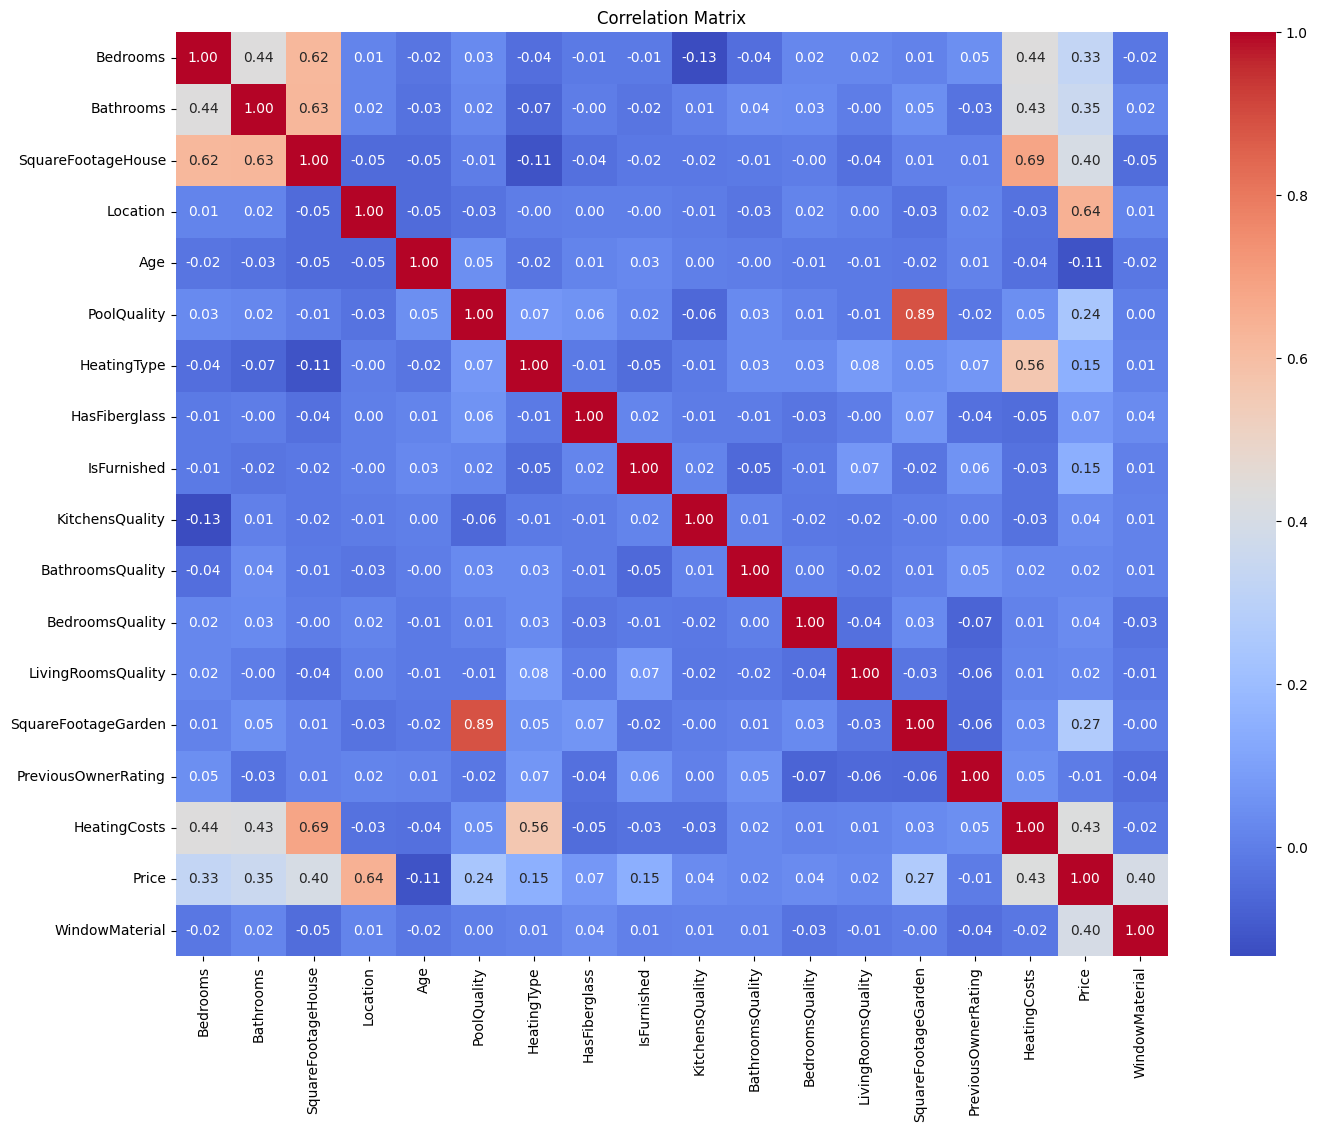

In [55]:
plot_correlation_matrix(df, 'pearson')

## Spearman Correlation Matrix

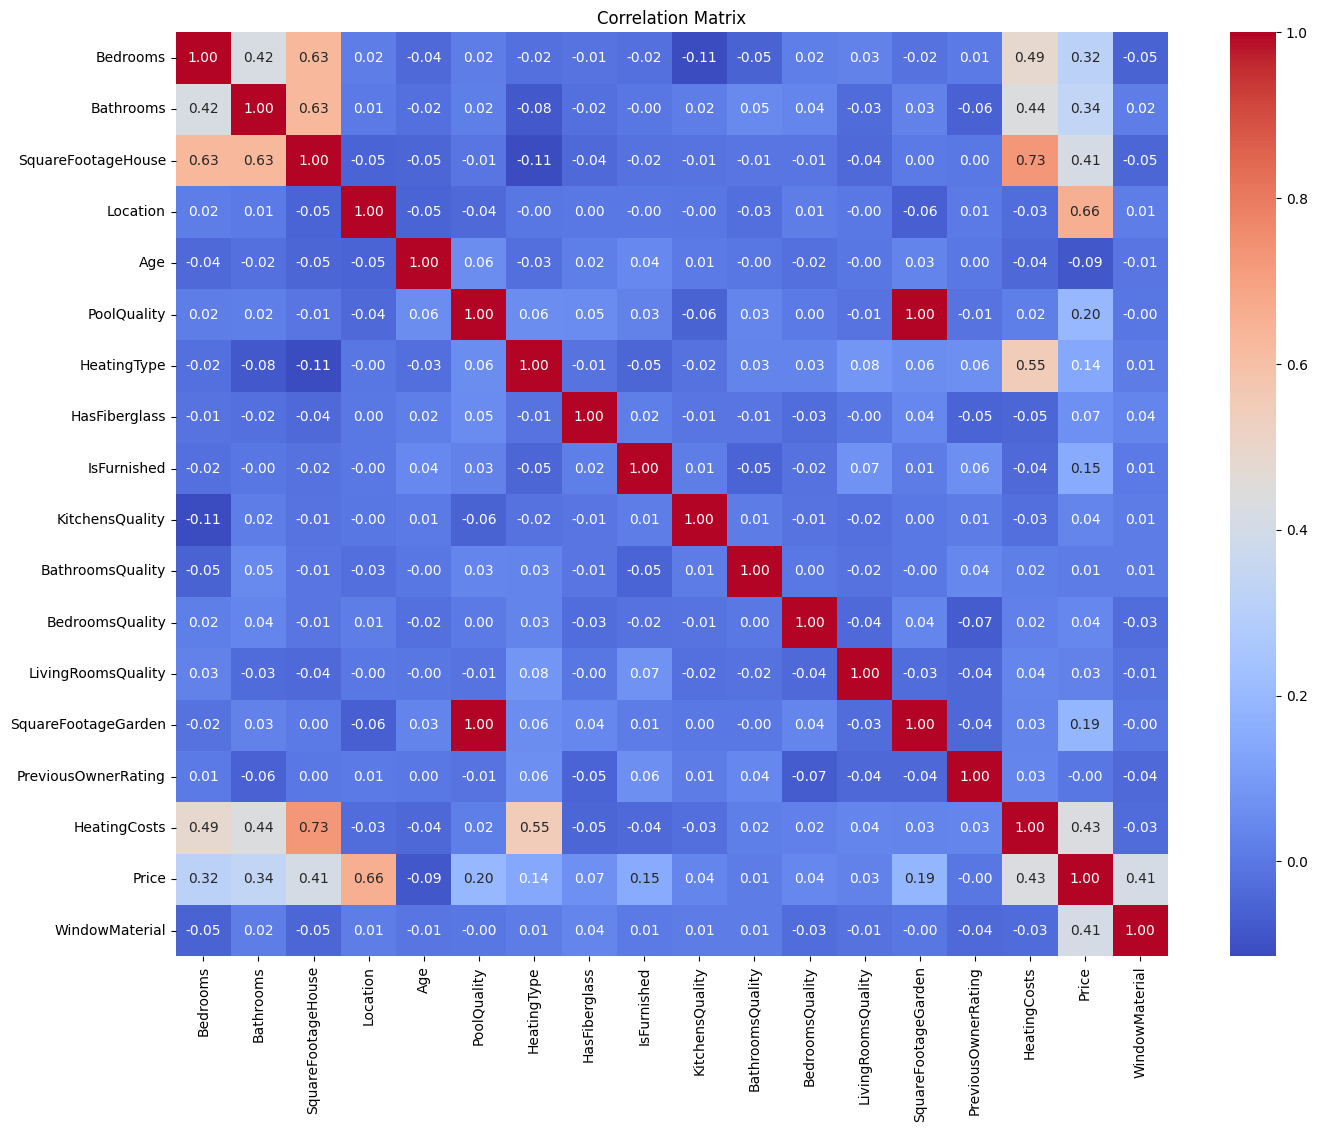

In [56]:
plot_correlation_matrix(df, 'spearman')

- **CorSpear(PoolQuality, SquareFootageGarden) = 1**
- **CorSpear(PoolQualityRank, Price) = 0.3**

# Remaining missing values

In [43]:
def print_missing_values(df):
    print("Data Entries: ", df.shape)

    print("\nDistribution % of Missing Values in Numerical Columns:")
    numerical_columns = df.select_dtypes(include=np.number).columns
    numerical_missing_distribution = df[numerical_columns].isnull().mean() * 100
    display(numerical_missing_distribution)

    print("\nDistribution % of Missing Values in Categorical Columns:")
    categorical_columns = [column for column in df.columns if column not in numerical_columns]
    categorical_missing_distribution = df[categorical_columns].isnull().mean() * 100
    display(categorical_missing_distribution)


print_missing_values(df)

Data Entries:  (941, 22)

Distribution % of Missing Values in Numerical Columns:


Bedrooms                8.076514
Bathrooms              23.804463
SquareFootageHouse      0.000000
Age                    15.621679
SquareFootageGarden     0.000000
PreviousOwnerRating     0.000000
HeatingCosts            0.000000
Price                   0.000000
dtype: float64


Distribution % of Missing Values in Categorical Columns:


Location               0.637620
PoolQuality           32.624867
HasPhotovoltaics      24.867163
HeatingType            0.000000
HasFiberglass          0.000000
IsFurnished            0.000000
DateSinceForSale       0.000000
HouseColor             5.313496
HasFireplace           0.000000
KitchensQuality        0.000000
BathroomsQuality       0.000000
BedroomsQuality        0.000000
LivingRoomsQuality     0.000000
WindowMaterial         0.000000
dtype: float64

# Things to do 
- How to deal with remaining missing values
  - Is it possible to infer from other available features the features which are missing?
  - `PoolQuality` see answer of Tutor in `eda.ipynb`
    - 1. Calculate Correlation Coefficent between `Age`
    - 2. If (1.) failed, drop the column
  - `Bedrooms` and `Bathrooms`: Is there a relationship? Pearson `r = 0.5`
  - `Age`: Impute with `mean or median`
  - `HasPhotovoltaics`
    - Train 1. Model: Dataframe with removed rows
    - Train 2. Model: Dataframe with missing values
  - `HouseColor`: Impute with most frequent color
- `SquareFootageGarden` as seen in [outliers section](#outlier_squarefootagegarden) has one cluster with large values across all area sizes
- `PreviousOwnerName`: ask @johan, if its correlated with `PreviousOwnerRating`
---

- `DateSinceForSale`: see `eda.ipynb`, compute additional column based on the string`
  - 1. Experiment: with original column
  - 2. Experiment: with new parsed feature
  - Prices for real estate are time-sensitive, maybe this feature is **crucial**?

## PoolQuality Imputation

TL;DR: `SquareFootageGarden` can be used to **fully** infer `PoolQuality` as `CorSpear(SquareFootageGarden, PoolQuality) = 1`

In [42]:
# Spearman Correlation between PoolQuality and NumericalFeatures
numerical_columns = df.select_dtypes(include=np.number).columns
numerical_columns = numerical_columns.drop(['PoolQuality'])
spearman_correlation = df[['PoolQuality'] + list(numerical_columns)].corr(method='spearman')
spearman_correlation = spearman_correlation['PoolQuality'].sort_values(ascending=False)

plt.figure(figsize=(15, 5))
spearman_correlation.drop('PoolQuality').plot(kind='bar', color='blue')
plt.title('Spearman Correlation between PoolQuality and Numerical Features')
plt.xlabel('Features')
plt.ylabel('Correlation')
plt.xticks(rotation=45)
plt.show()


KeyError: "['PoolQuality'] not found in axis"

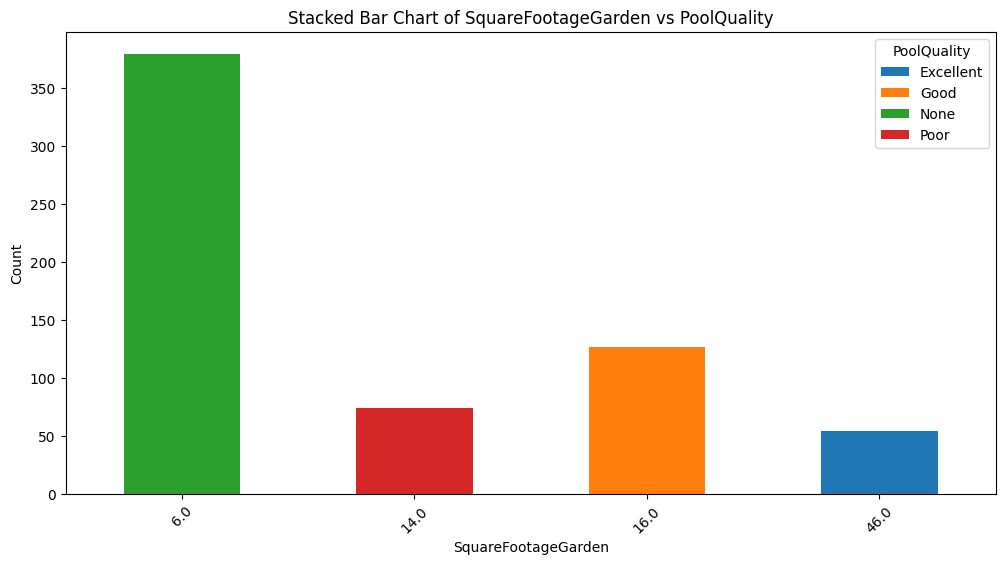

In [40]:
# Stacked Bar Chart for each SquareFootageGarden that shows the distribution of PoolQuality
pivot_table = df.pivot_table(index='SquareFootageGarden', columns='PoolQuality', aggfunc='size', fill_value=0)
pivot_table.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Stacked Bar Chart of SquareFootageGarden vs PoolQuality')
plt.xlabel('SquareFootageGarden')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [44]:
df['SquareFootageGarden'].unique()

array([16., 46.,  6., 14.])

In [45]:
map_squarefootagegarden_poolquality = { 6: 'NoPool', # None
                                        14: 'Poor', # Poor
                                        16: 'Good', # Good
                                        46: 'Excellent'} # Excellent

for squarefootagegarden, poolquality in map_squarefootagegarden_poolquality.items():
    df.loc[df['SquareFootageGarden'] == squarefootagegarden, 'PoolQuality'] = poolquality

# # Sync Ranks
# df['PoolQuality'] = df['PoolQuality'].replace(quality_rank_mapping)

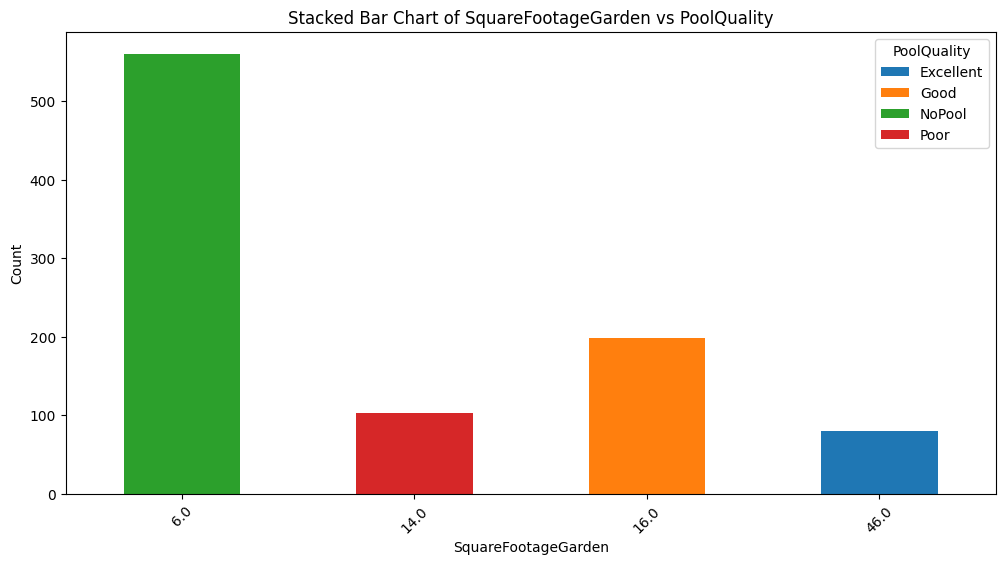

In [46]:
pivot_table = df.pivot_table(index='SquareFootageGarden', columns='PoolQuality', aggfunc='size', fill_value=0)
pivot_table.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Stacked Bar Chart of SquareFootageGarden vs PoolQuality')
plt.xlabel('SquareFootageGarden')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [47]:
# Print missing values for pool qualtiy rank
print("Missing Values: {:.2f}%".format(df['PoolQuality'].isnull().sum() / df.shape[0] * 100))

Missing Values: 0.00%


## Bedrooms

In [48]:
print(f"Missing: {df['Bedrooms'].isnull().mean() * 100:.2f}%")

Missing: 8.08%


In [49]:
print(f"Cor(Bedrooms, SquareFootageHouse) = {df['Bedrooms'].corr(df['SquareFootageHouse'])}")

Cor(Bedrooms, SquareFootageHouse) = 0.61975191121425


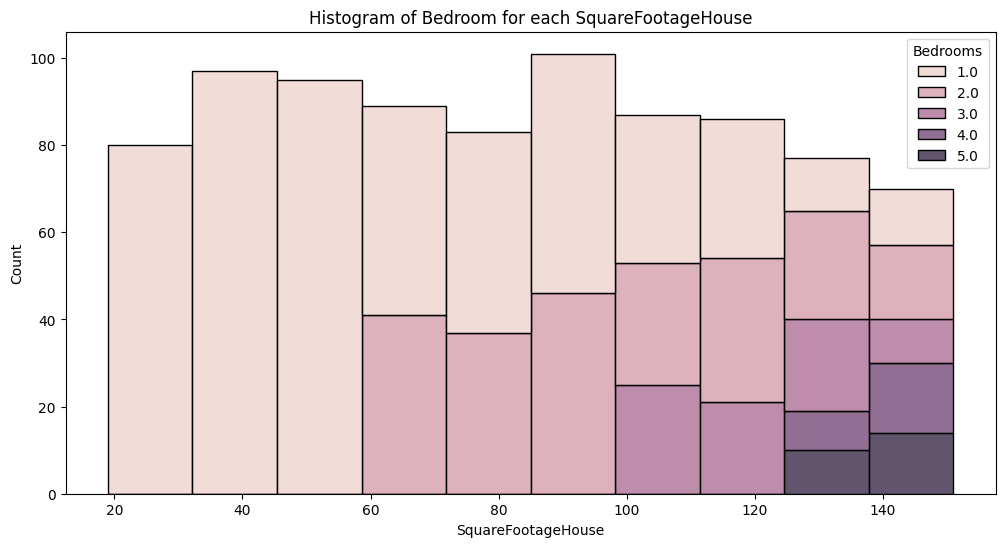

In [50]:
# SquareFootageHouse histogram for each bedroom
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='SquareFootageHouse', hue='Bedrooms', multiple='stack', bins=10)
plt.title('Histogram of Bedroom for each SquareFootageHouse')
plt.xlabel('SquareFootageHouse')
plt.ylabel('Count')
plt.show()

In [51]:
# Create SquareFootageHouse bins
squarefootagehouse_bins = pd.cut(df['SquareFootageHouse'], bins=4)
print(squarefootagehouse_bins.value_counts())

SquareFootageHouse
(85.0, 118.0]     254
(18.868, 52.0]    247
(52.0, 85.0]      236
(118.0, 151.0]    204
Name: count, dtype: int64


In [52]:
# Impute Bedroom by SquareFootageHouse using the median per square fgroup
df['Bedrooms'] = df['Bedrooms'].fillna(df.groupby(squarefootagehouse_bins)['Bedrooms'].transform('median'))

C:\Users\alexb\AppData\Local\Temp\ipykernel_26472\2146002058.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['Bedrooms'] = df['Bedrooms'].fillna(df.groupby(squarefootagehouse_bins)['Bedrooms'].transform('median'))


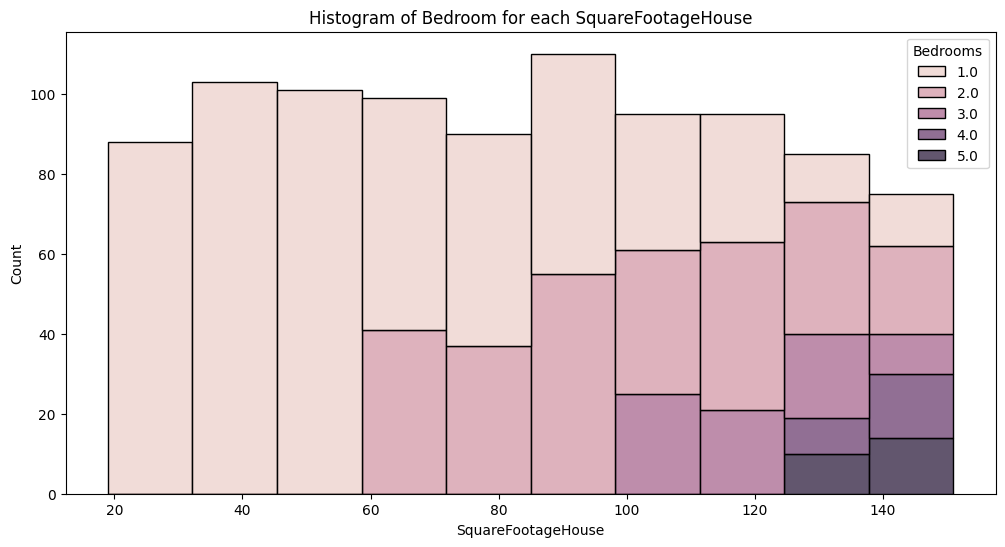

In [53]:
# SquareFootageHouse histogram for each bedroom
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='SquareFootageHouse', hue='Bedrooms', multiple='stack', bins=10)
plt.title('Histogram of Bedroom for each SquareFootageHouse')
plt.xlabel('SquareFootageHouse')
plt.ylabel('Count')
plt.show()

In [54]:
# Print missing bedroom values
print(f"Missing: {df['Bedrooms'].isnull().mean() * 100:.2f}%")

Missing: 0.00%


## Bathrooms

In [55]:
bedrooms_categories = df['Bedrooms'].unique()

df['Bedrooms'].describe()
df['Bathrooms'].describe()

print("Bathroom missing: {:.2f}%".format(df[(df['Bathrooms'].isnull())].shape[0] / df.shape[0] * 100))
print("Bedroom missing: {:.2f}%".format(df[(df['Bedrooms'].isnull())].shape[0] / df.shape[0] * 100))
print("Both Missing: {:.2f}%".format(df[(df['Bedrooms'].isnull()) & (df['Bathrooms'].isnull())].shape[0] / df.shape[0] * 100))

Bathroom missing: 23.80%
Bedroom missing: 0.00%
Both Missing: 0.00%


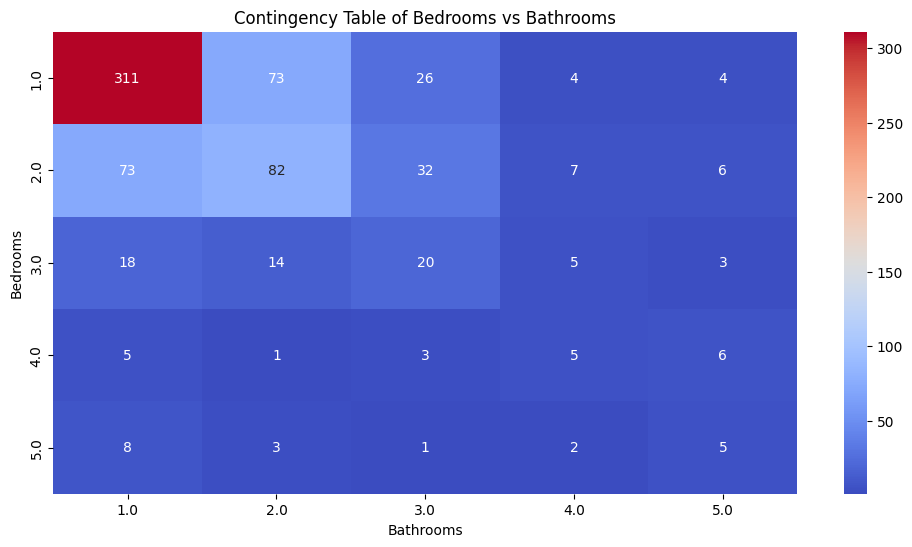

In [56]:
# Contingency Table "Bedrooms" and "Bathrooms"
contingency_table = pd.crosstab(df['Bedrooms'], df['Bathrooms'])
contingency_table

# plot the contingency table
plt.figure(figsize=(12, 6))
sns.heatmap(contingency_table, annot=True, fmt='d', cmap='coolwarm')
plt.title('Contingency Table of Bedrooms vs Bathrooms')
plt.xlabel('Bathrooms')
plt.ylabel('Bedrooms')
plt.show()


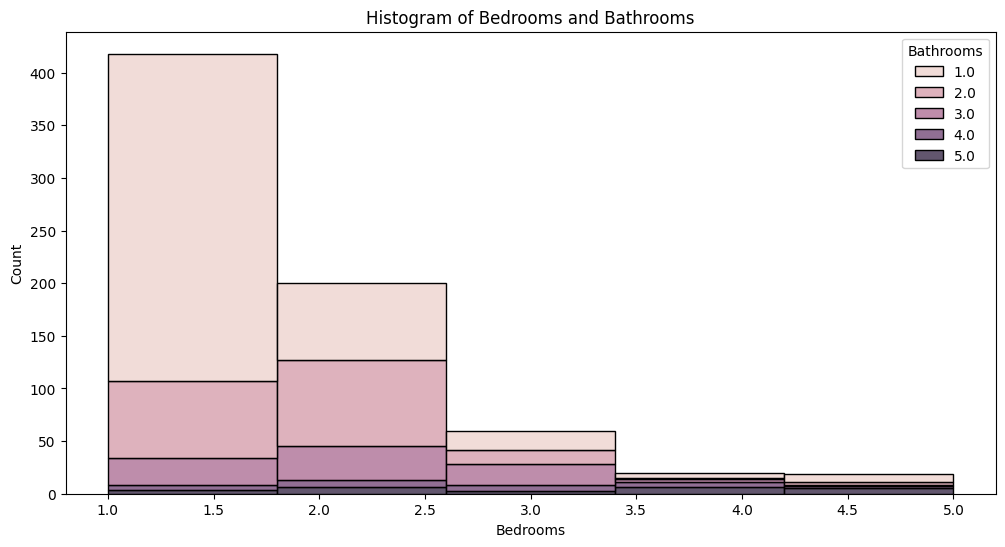

Bedrooms = 1


count    418.000000
mean       1.366029
std        0.727991
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max        5.000000
Name: Bathrooms, dtype: float64

Bedrooms = 2


count    200.00000
mean       1.95500
std        0.96833
min        1.00000
25%        1.00000
50%        2.00000
75%        2.00000
max        5.00000
Name: Bathrooms, dtype: float64

Bedrooms = 3


count    60.000000
mean      2.350000
std       1.147215
min       1.000000
25%       1.000000
50%       2.000000
75%       3.000000
max       5.000000
Name: Bathrooms, dtype: float64

Bedrooms = 4


count    20.000000
mean      3.300000
std       1.592747
min       1.000000
25%       1.750000
50%       4.000000
75%       5.000000
max       5.000000
Name: Bathrooms, dtype: float64

Bedrooms = 5


count    19.000000
mean      2.631579
std       1.738790
min       1.000000
25%       1.000000
50%       2.000000
75%       4.500000
max       5.000000
Name: Bathrooms, dtype: float64

In [57]:
# Histogram of Bedrooms and Bathrooms
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='Bedrooms', hue='Bathrooms', multiple='stack', bins=5)
plt.title('Histogram of Bedrooms and Bathrooms')
plt.xlabel('Bedrooms')
plt.ylabel('Count')
plt.show()


# For Bedrooms =1, plot distribution of Bathrooms

for bedroom in range(1, 6):
   
    # Print statstics
    print(f"Bedrooms = {bedroom}")
    display(df[df['Bedrooms'] == bedroom]['Bathrooms'].describe())
    mode = df[df['Bedrooms'] == bedroom]['Bathrooms'].mode()

In [58]:
# For each category of bedroom, impute the missing value for bathrooms by using the median

for bedroom in range(1, 6):
    median_bathrooms = df[df['Bedrooms'] == bedroom]['Bathrooms'].median()

    df.loc[(df['Bedrooms'] == bedroom) & (df['Bathrooms'].isnull()), 'Bathrooms'] = median_bathrooms

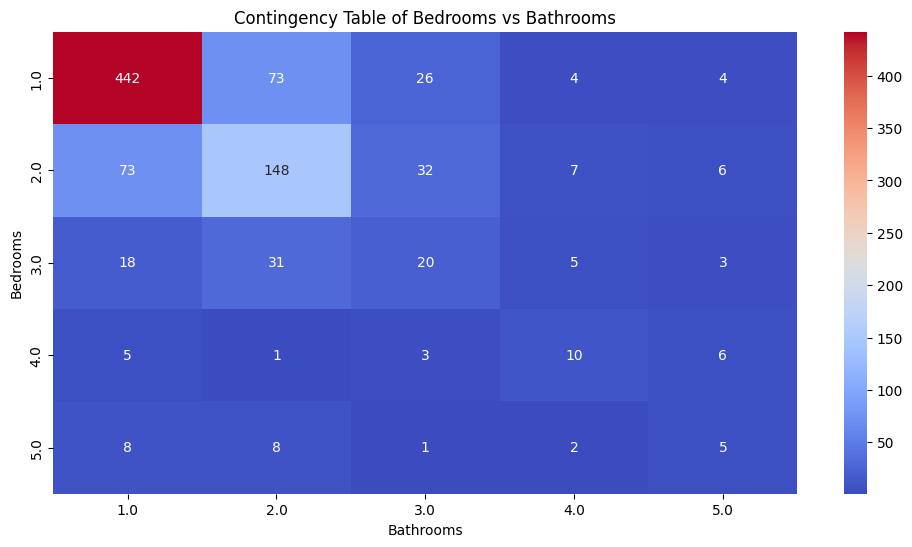

Bathroom missing: 0.00%
Bedroom missing: 0.00%
Both Missing: 0.00%


In [59]:
# Contingency Table "Bedrooms" and "Bathrooms"
contingency_table = pd.crosstab(df['Bedrooms'], df['Bathrooms'])
contingency_table

# plot the contingency table
plt.figure(figsize=(12, 6))
sns.heatmap(contingency_table, annot=True, fmt='d', cmap='coolwarm')
plt.title('Contingency Table of Bedrooms vs Bathrooms')
plt.xlabel('Bathrooms')
plt.ylabel('Bedrooms')
plt.show()

print("Bathroom missing: {:.2f}%".format(df[(df['Bathrooms'].isnull())].shape[0] / df.shape[0] * 100))
print("Bedroom missing: {:.2f}%".format(df[(df['Bedrooms'].isnull())].shape[0] / df.shape[0] * 100))
print("Both Missing: {:.2f}%".format(df[(df['Bedrooms'].isnull()) & (df['Bathrooms'].isnull())].shape[0] / df.shape[0] * 100))

## Age

In [60]:
df['Age'].describe()
print("Missing: {:.2f}%".format(df['Age'].isnull().mean() * 100))

Missing: 15.62%


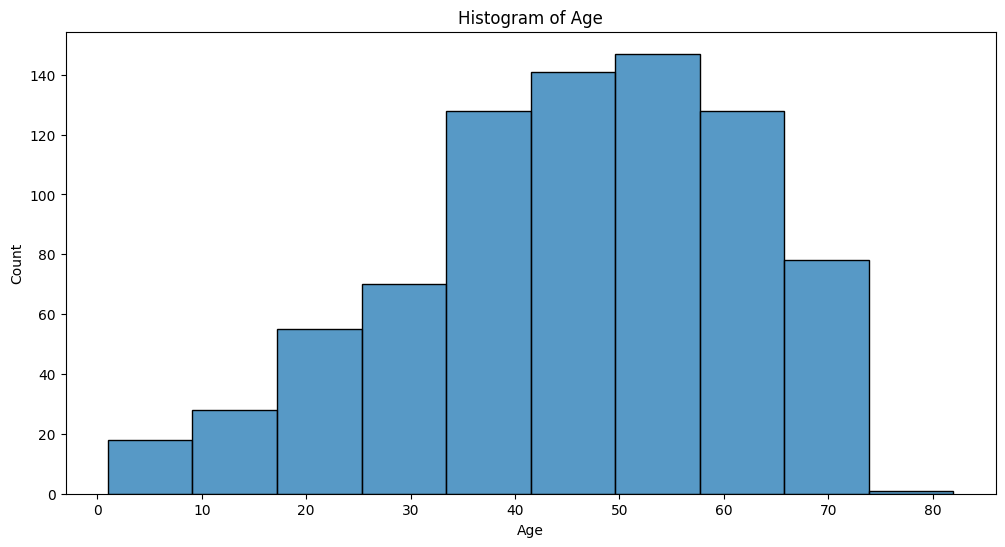

In [61]:
# Age histogram
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='Age', bins=10)
plt.title('Histogram of Age')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

In [62]:
# Impute missing values for age using mean
df['Age'] = df['Age'].fillna(df['Age'].median())

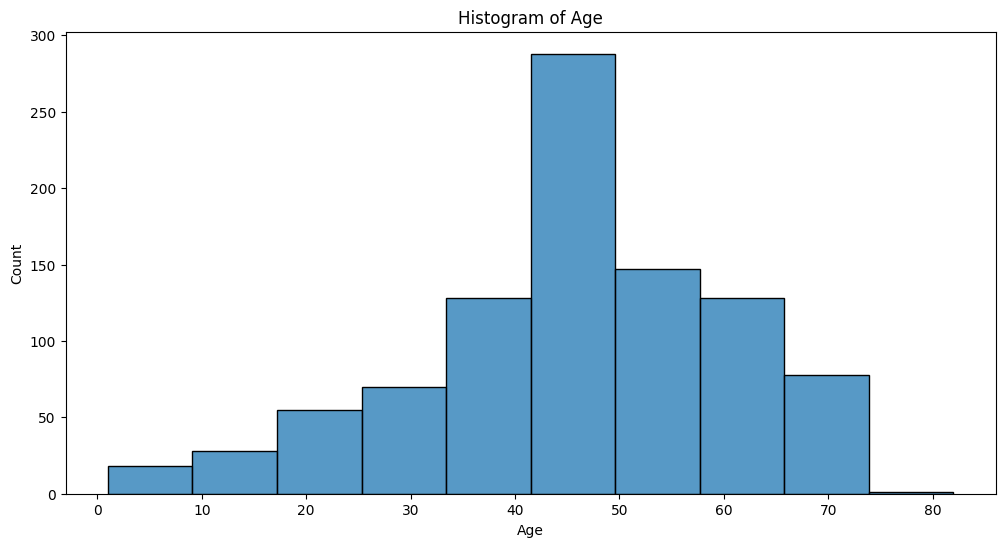

In [63]:
# Age histogram
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='Age', bins=10)
plt.title('Histogram of Age')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

In [59]:
print("Missing: {:.2f}%".format(df['Age'].isnull().mean() * 100))
df['Age'].describe()

Missing: 0.00%


count    941.000000
mean      45.702444
std       14.611082
min        1.000000
25%       38.000000
50%       47.000000
75%       56.000000
max       82.000000
Name: Age, dtype: float64

## HouseColor

Missing: 5.31%


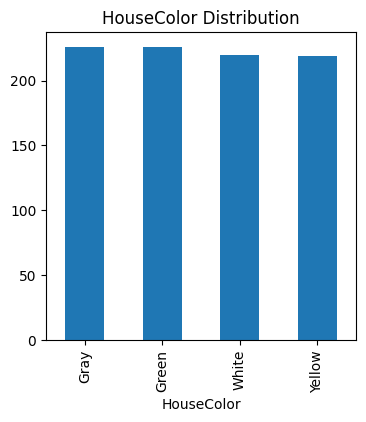

In [64]:
print("Missing: {:.2f}%".format(df['HouseColor'].isnull().mean() * 100))

# Hist
plt.figure(figsize=(4, 4))
df['HouseColor'].value_counts().plot(kind='bar')
plt.title('HouseColor Distribution')
plt.xlabel('HouseColor')
plt.show()

In [65]:
# Impute with mode
df['HouseColor'] = df['HouseColor'].fillna(df['HouseColor'].mode()[0])

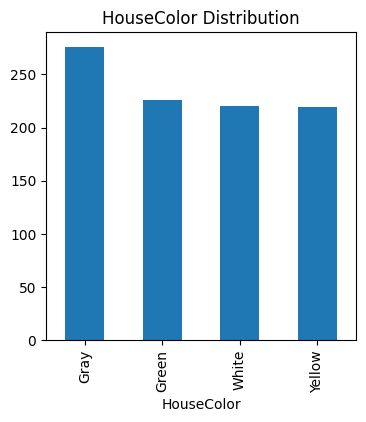

In [66]:
plt.figure(figsize=(4, 4))
df['HouseColor'].value_counts().plot(kind='bar')
plt.title('HouseColor Distribution')
plt.xlabel('HouseColor')
plt.show()

In [67]:
print_missing_values(df)

Data Entries:  (941, 22)

Distribution % of Missing Values in Numerical Columns:


Bedrooms               0.0
Bathrooms              0.0
SquareFootageHouse     0.0
Age                    0.0
SquareFootageGarden    0.0
PreviousOwnerRating    0.0
HeatingCosts           0.0
Price                  0.0
dtype: float64


Distribution % of Missing Values in Categorical Columns:


Location               0.637620
PoolQuality            0.000000
HasPhotovoltaics      24.867163
HeatingType            0.000000
HasFiberglass          0.000000
IsFurnished            0.000000
DateSinceForSale       0.000000
HouseColor             0.000000
HasFireplace           0.000000
KitchensQuality        0.000000
BathroomsQuality       0.000000
BedroomsQuality        0.000000
LivingRoomsQuality     0.000000
WindowMaterial         0.000000
dtype: float64

# Final Data Set of Preprocessing

In [68]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 941 entries, 0 to 999
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Bedrooms             941 non-null    float64       
 1   Bathrooms            941 non-null    float64       
 2   SquareFootageHouse   941 non-null    float64       
 3   Location             935 non-null    object        
 4   Age                  941 non-null    float64       
 5   PoolQuality          941 non-null    object        
 6   HasPhotovoltaics     707 non-null    object        
 7   HeatingType          941 non-null    object        
 8   HasFiberglass        941 non-null    object        
 9   IsFurnished          941 non-null    object        
 10  DateSinceForSale     941 non-null    datetime64[ns]
 11  HouseColor           941 non-null    object        
 12  HasFireplace         941 non-null    object        
 13  KitchensQuality      941 non-null    obj

In [69]:
print_missing_values(df)

Data Entries:  (941, 22)

Distribution % of Missing Values in Numerical Columns:


Bedrooms               0.0
Bathrooms              0.0
SquareFootageHouse     0.0
Age                    0.0
SquareFootageGarden    0.0
PreviousOwnerRating    0.0
HeatingCosts           0.0
Price                  0.0
dtype: float64


Distribution % of Missing Values in Categorical Columns:


Location               0.637620
PoolQuality            0.000000
HasPhotovoltaics      24.867163
HeatingType            0.000000
HasFiberglass          0.000000
IsFurnished            0.000000
DateSinceForSale       0.000000
HouseColor             0.000000
HasFireplace           0.000000
KitchensQuality        0.000000
BathroomsQuality       0.000000
BedroomsQuality        0.000000
LivingRoomsQuality     0.000000
WindowMaterial         0.000000
dtype: float64

## Pearson Correlation Matrix

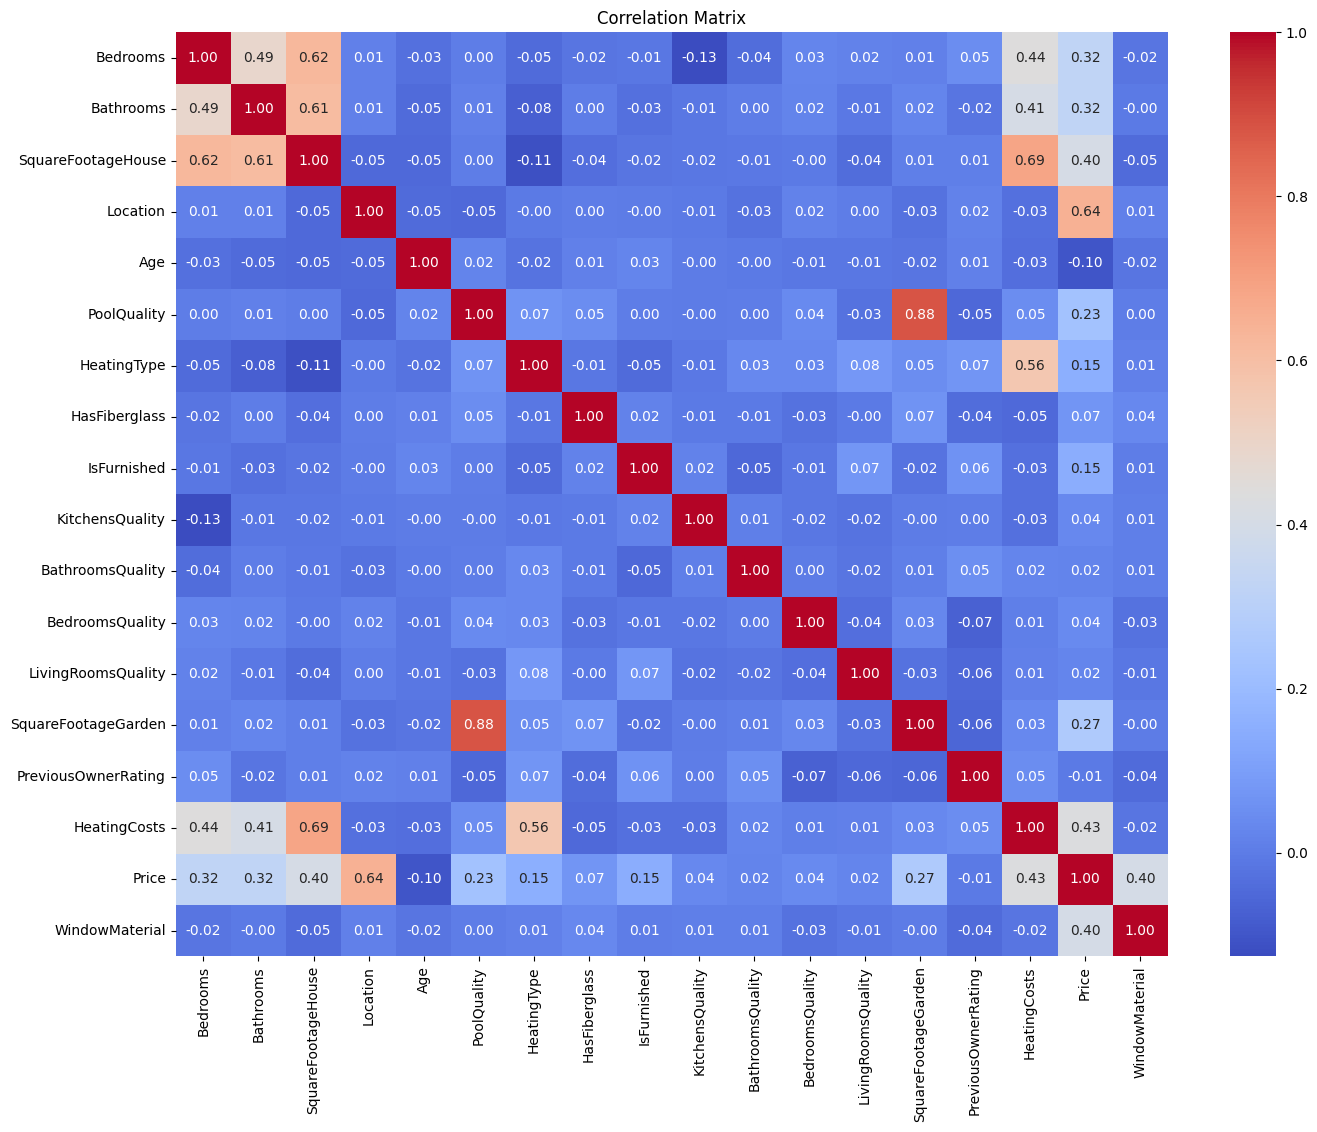

In [87]:
plot_correlation_matrix(df, 'pearson')

## Spearman Correlation Matrix

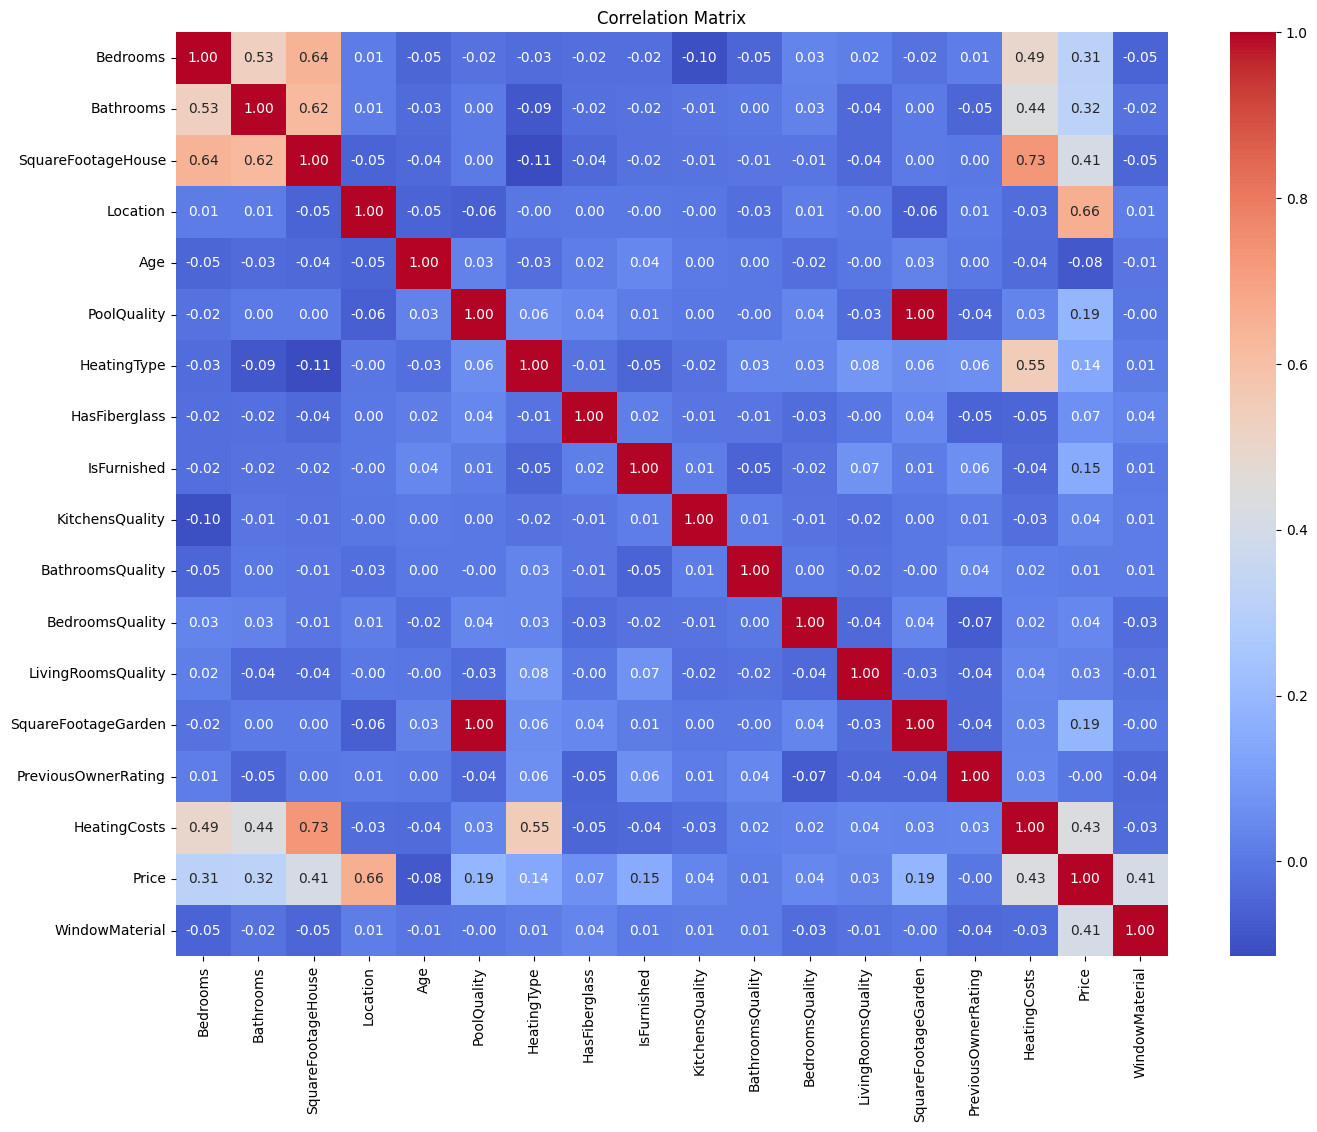

In [88]:
plot_correlation_matrix(df, 'spearman')

## Dataset 1 - With NaN - HasPhotovoltaics

In [89]:
# Save the dataframe as csv "preprocessed_data1.csv"
df.to_csv('../files/preprocessed_1.csv', index=False)

## Dataset 2 - Without NaN HasPhotovoltaics

In [81]:
_df = df.copy()
_df = _df.dropna(subset=['Location'])
_df = _df.drop(columns=['DateSinceForSale'])

In [82]:
_df['HasPhotovoltaics'] = _df['HasPhotovoltaics'].fillna('Missing')

In [83]:
_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 935 entries, 0 to 999
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Bedrooms             935 non-null    float64
 1   Bathrooms            935 non-null    float64
 2   SquareFootageHouse   935 non-null    float64
 3   Location             935 non-null    object 
 4   Age                  935 non-null    float64
 5   PoolQuality          935 non-null    object 
 6   HasPhotovoltaics     935 non-null    object 
 7   HeatingType          935 non-null    object 
 8   HasFiberglass        935 non-null    object 
 9   IsFurnished          935 non-null    object 
 10  HouseColor           935 non-null    object 
 11  HasFireplace         935 non-null    object 
 12  KitchensQuality      935 non-null    object 
 13  BathroomsQuality     935 non-null    object 
 14  BedroomsQuality      935 non-null    object 
 15  LivingRoomsQuality   935 non-null    object 


In [84]:
_df.to_csv('../files/preprocessed_3_without_DateSinceForSale_HasPhotovoltaics_filled.csv', index=False)

# TODOS 2024-05-10

- [ ] Predict Bathrooms from correlated features using a ML Model
- [ ] Modelling - 1st 2024-05-24 08:30 

In [66]:
df['HasPhotovoltaics'].unique()

array([False, True, nan], dtype=object)

In [67]:
df['HasPhotovoltaics'] = df['HasPhotovoltaics'].fillna('isNone')
df['HasPhotovoltaics'] = df['HasPhotovoltaics'].replace({True: 'isTrue', False: 'isFalse'})
df['HasPhotovoltaics'].unique()

array(['isFalse', 'isTrue', 'isNone'], dtype=object)

In [68]:
df.to_csv('../files/preprocessed_3.csv', index=False)

In [69]:
df.copy().drop(columns=['DateSinceForSale']).to_csv('../files/preprocessed_3_without_DateSinceForSale.csv', index=False)

In [82]:
df = pd.read_csv('../files/preprocessed_2_without_DateSinceForSale.csv', keep_default_na=False, na_values=["isNone"])

In [83]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 707 entries, 0 to 706
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Bedrooms             707 non-null    float64
 1   Bathrooms            707 non-null    float64
 2   SquareFootageHouse   707 non-null    float64
 3   Location             707 non-null    object 
 4   Age                  707 non-null    float64
 5   PoolQuality          707 non-null    float64
 6   HasPhotovoltaics     707 non-null    bool   
 7   HeatingType          707 non-null    int64  
 8   HasFiberglass        707 non-null    int64  
 9   IsFurnished          707 non-null    int64  
 10  HouseColor           707 non-null    object 
 11  HasFireplace         707 non-null    bool   
 12  KitchensQuality      707 non-null    int64  
 13  BathroomsQuality     707 non-null    int64  
 14  BedroomsQuality      707 non-null    int64  
 15  LivingRoomsQuality   707 non-null    int

In [87]:
df.dropna().to_csv('../files/preprocessed_3_without_DateSinceForSale_v2.csv', index=False)

In [88]:
df['HasFiberglass'].unique()

array([1, 0], dtype=int64)

In [86]:
df.dropna().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 707 entries, 0 to 706
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Bedrooms             707 non-null    float64
 1   Bathrooms            707 non-null    float64
 2   SquareFootageHouse   707 non-null    float64
 3   Location             707 non-null    object 
 4   Age                  707 non-null    float64
 5   PoolQuality          707 non-null    float64
 6   HasPhotovoltaics     707 non-null    bool   
 7   HeatingType          707 non-null    int64  
 8   HasFiberglass        707 non-null    int64  
 9   IsFurnished          707 non-null    int64  
 10  HouseColor           707 non-null    object 
 11  HasFireplace         707 non-null    bool   
 12  KitchensQuality      707 non-null    int64  
 13  BathroomsQuality     707 non-null    int64  
 14  BedroomsQuality      707 non-null    int64  
 15  LivingRoomsQuality   707 non-null    int